In [136]:
import pandas as pd

df = pd.read_csv('C:/Users/carlos.isaacf/Desktop/DS_PORTFOLIO/Notebooks/Online_Retail_.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


# Cálculo de las métricas RFM

Calculamos las métricas Recency, Frequency y Monetary (RFM) para cada cliente. Recency se calcula como el número de días entre la fecha de la última compra del cliente y la fecha más reciente en los datos. Frequency se calcula como el número total de compras realizadas por cada cliente (considerando una factura (InvoiceNo) como una compra). Monetary se calcula como el total de dinero gastado por cada cliente.


In [137]:
# Convertir 'InvoiceDate' al formato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calcular Recency, Frequency y Monetary para cada cliente
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Recency: la cantidad de días desde la última compra
recency = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: (snapshot_date - x.max()).days)

# Frequency: la cantidad de compras únicas (facturas únicas)
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary: la suma total de las ventas
monetary = df.groupby('CustomerID')['TotalSales'].sum()

# Crear un DataFrame RFM
rfm_data = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary}).reset_index()
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


# Creación de los cuartiles RFM y cálculo de la puntuación RFM total

Dividimos a los clientes en cuatro cuartiles en función de sus métricas Recency, Frequency y Monetary. Luego, calculamos una puntuación RFM total para cada cliente sumando los valores de los cuartiles RFM.


In [138]:
# Crear cuartiles RFM
rfm_data['RecencyQ'] = pd.qcut(rfm_data['Recency'], 4, labels=False, duplicates='drop') + 1
rfm_data['FrequencyQ'] = pd.qcut(rfm_data['Frequency'], 4, labels=False, duplicates='drop') + 1
rfm_data['MonetaryQ'] = pd.qcut(rfm_data['Monetary'], 4, labels=False, duplicates='drop') + 1

# Calcular la puntuación RFM total
rfm_data['RFM_Score'] = rfm_data['RecencyQ'] + rfm_data['FrequencyQ'] + rfm_data['MonetaryQ']
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,RecencyQ,FrequencyQ,MonetaryQ,RFM_Score
0,12346,326,2,0.00,4,1,1,6
1,12347,2,7,4310.00,1,3,4,8
2,12348,75,4,1797.24,3,2,4,9
3,12349,19,1,1757.55,2,1,4,7
4,12350,310,1,334.40,4,1,2,7


# Segmentación de los clientes en función de la puntuación RFM

Segmentamos a los clientes en tres grupos (`Bronce`, `Plata`, `Oro`) en función de su puntuación RFM. Este tipo de segmentación puede ser muy útil para desarrollar estrategias de marketing personalizadas para diferentes segmentos de clientes.


In [139]:
# Definir una función para asignar segmentos en base a la puntuación RFM total
def segment_rfm(rfm_score):
    if rfm_score <= 4:
        return 'Bronce'
    elif rfm_score <= 7:
        return 'Plata'
    else:
        return 'Oro'

# Aplicar la función de segmentación
rfm_data['Segment'] = rfm_data['RFM_Score'].apply(segment_rfm)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,RecencyQ,FrequencyQ,MonetaryQ,RFM_Score,Segment
0,12346,326,2,0.00,4,1,1,6,Plata
1,12347,2,7,4310.00,1,3,4,8,Oro
2,12348,75,4,1797.24,3,2,4,9,Oro
3,12349,19,1,1757.55,2,1,4,7,Plata
4,12350,310,1,334.40,4,1,2,7,Plata


# Análisis de los segmentos de clientes

Calculamos el valor medio de Recency, Frequency y Monetary para cada segmento de clientes, y también contamos el número de clientes en cada segmento. Este análisis nos ayuda a entender las características de cada segmento de clientes.


In [140]:
# Resumen de los segmentos
segment_summary = rfm_data.groupby('Segment').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max', 'count']
})

segment_summary.sort_values([('Monetary', 'mean')], ascending=False)

Recency          Frequency           Monetary                      \
           mean min  max      mean min   max     mean      min        max   
Segment                                                                     
Oro       63.33   1  372     12.74   1  2259  5845.11   -71.46 1448167.36   
Plata    119.50   1  374      2.38   1    15   601.07 -4287.63   12393.70   
Bronce    19.73   1   50      1.64   1     5   250.35  -134.80     642.80   

               
        count  
Segment        
Oro      1386  
Plata    2563  
Bronce    423

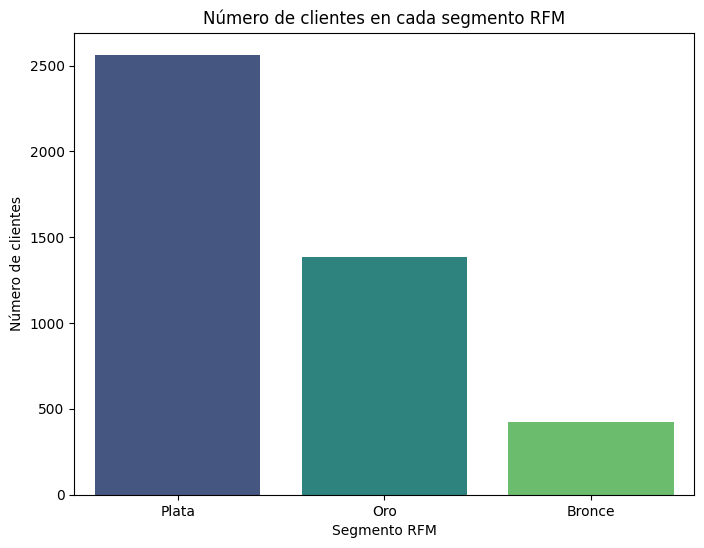

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot de número de clientes en cada segmento RFM
rfm_segment_counts = rfm_data['Segment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=rfm_segment_counts.index, y=rfm_segment_counts.values, palette='viridis')
plt.title('Número de clientes en cada segmento RFM')
plt.xlabel('Segmento RFM')
plt.ylabel('Número de clientes')
plt.show()


## Distribución de puntuaciones RFM

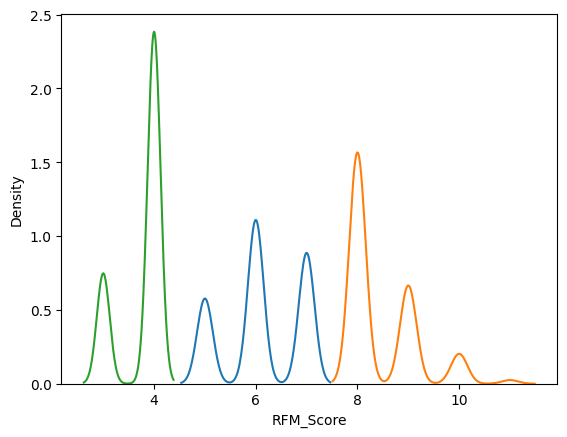

In [142]:
for segment in rfm_data['Segment'].unique():
    subset = rfm_data[rfm_data['Segment'] == segment]
    sns.distplot(subset['RFM_Score'], hist = False, kde = True, label = segment)


# Conclusión análisis `RFM`

``Segmento Oro``:
Este segmento contiene 1386 clientes. Los clientes en este segmento tienen una recency media de 63, lo que indica que en promedio han realizado una compra recientemente. La frecuencia media es alta, alrededor de 12.73, lo que sugiere que los clientes de este segmento realizan compras con frecuencia. El valor monetario medio es muy alto, alrededor de 5845, lo que indica que los clientes de este segmento tienden a gastar mucho. Sin embargo, hay una amplia gama de valores monetarios en este grupo, con un mínimo de -71.46 y un máximo de 1448167.36.

``Segmento Plata``:
Este segmento contiene 2563 clientes. Los clientes en este segmento tienen una recency media de 119.5, lo que indica que en promedio ha pasado un tiempo considerable desde su última compra. La frecuencia media es de alrededor de 2.38, lo que sugiere que los clientes de este segmento realizan compras con una frecuencia moderada. El valor monetario medio es de alrededor de 601, lo que indica que los clientes de este segmento tienden a gastar una cantidad moderada. Sin embargo, hay una amplia gama de valores monetarios en este grupo, con un mínimo de -4287.63 y un máximo de 12393.70.

``Segmento Bronce``:
Este segmento contiene 423 clientes. Los clientes en este segmento tienen una recency media baja de alrededor de 20, lo que indica que en promedio han realizado una compra bastante reciente. La frecuencia media es de alrededor de 1.64, lo que sugiere que los clientes de este segmento realizan compras con poca frecuencia. El valor monetario medio es de alrededor de 250, lo que indica que los clientes de este segmento tienden a gastar menos.

En resumen, el segmento Oro parece contener a los clientes más valiosos, con una alta frecuencia y un alto valor monetario. El segmento Bronce tiene clientes que compran con poca frecuencia y gastan menos, mientras que el segmento Plata tiene clientes que compran con una frecuencia moderada y gastan una cantidad moderada.

# K-means
## Estandarización de las características RFM
Para preparar nuestros datos para el algoritmo K-means, necesitamos estandarizar las características RFM. Esto se debe a que K-means es sensible a la escala de las variables y puede dar más importancia a las variables con una mayor escala. Al estandarizar las características, nos aseguramos de que todas ellas tengan la misma escala y contribuyan de manera igual al algoritmo K-means.


In [143]:
from sklearn.preprocessing import StandardScaler

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Normalizar las características RFM
rfm_normalized = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])
rfm_normalized

array([[ 2.32198203, -0.10162724, -0.09542955],
       [-0.8936515 ,  0.0398561 ,  0.08904481],
       [-0.16914148, -0.0450339 , -0.01850503],
       ...,
       [-0.83410273, -0.07333057, -0.08787081],
       [-0.87380191,  0.29452612, -0.0057656 ],
       [-0.48673491, -0.07333057, -0.01679126]])

# Determinación del número óptimo de grupos

Para determinar el número óptimo de grupos para el algoritmo K-means, utilizamos el método del codo. Este método implica calcular la inercia (la suma de las distancias al cuadrado de cada dato a su centroide más cercano) para diferentes valores de K, y seleccionar el valor de K en el que la disminución de la inercia comienza a disminuir rápidamente. Graficamos la inercia en función del número de grupos para visualizar el "codo".


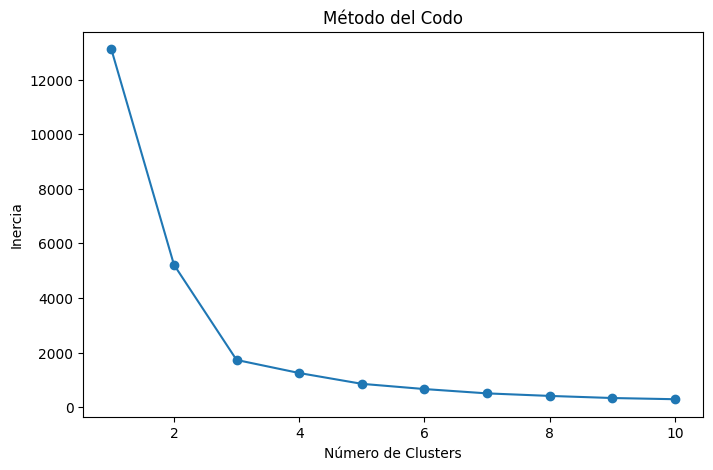

In [144]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Crear una lista para almacenar las inercias
inertias = []

# Probar diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

# Ajuste del algoritmo K-means

Ajustamos el algoritmo K-means a nuestros datos utilizando el número óptimo de grupos que obtuvimos con el método del codo. Luego, asignamos cada cliente a su grupo correspondiente.


In [145]:
# Crear un objeto KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=1)  # Cambia 3 al número óptimo de clusters

# Ajustar el modelo a los datos normalizados
kmeans.fit(rfm_normalized)

# Añadir las etiquetas de los clusters al DataFrame rfm_data
rfm_data['Cluster'] = kmeans.labels_

# Verificar los resultados
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,RecencyQ,FrequencyQ,MonetaryQ,RFM_Score,Segment,Cluster
0,12346,326,2,0.00,4,1,1,6,Plata,2
1,12347,2,7,4310.00,1,3,4,8,Oro,3
2,12348,75,4,1797.24,3,2,4,9,Oro,3
3,12349,19,1,1757.55,2,1,4,7,Plata,3
4,12350,310,1,334.40,4,1,2,7,Plata,2


# Análisis de los grupos de clientes

Finalmente, calculamos el valor medio de Recency, Frequency y Monetary para cada grupo de clientes, y también contamos el número de clientes en cada grupo. Este análisis nos ayuda a entender las características de cada grupo de clientes y puede ser útil para desarrollar estrategias de marketing específicas para cada grupo.


In [146]:
# Calcular la media de 'Monetary' para cada cluster
cluster_avg_monetary = rfm_data.groupby('Cluster')['Monetary'].mean()

# Ordenar los clusters por el valor promedio de 'Monetary'
sorted_clusters = cluster_avg_monetary.sort_values(ascending=False).index

# Crear un diccionario para mapear los clusters a los nuevos nombres
cluster_names = {cluster: name for cluster, name in zip(sorted_clusters, ['Especial', 'Oro', 'Plata', 'Bronce'])}

# Asignar los nuevos nombres a los clusters
rfm_data['Cluster'] = rfm_data['Cluster'].map(cluster_names)


# Calcular estadísticas descriptivas para cada grupo
group_stats = rfm_data.groupby('Cluster').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max', 'count']  # count para obtener el tamaño del grupo
})

group_stats.sort_values([('Monetary', 'mean')], ascending=False)


Recency           Frequency               Monetary             \
            mean  min  max      mean   min   max       mean        min   
Cluster                                                                  
Especial    1.00    1    1   2259.00  2259  2259 1448167.36 1448167.36   
Oro        31.02    1   92      6.54     1   248    2557.20   -1165.30   
Plata     152.46   91  223      2.55     1    14     704.83   -4287.63   
Bronce    295.37  225  374      1.56     1    35     404.90   -1192.20   

                           
                max count  
Cluster                    
Especial 1448167.36     1  
Oro       279489.02  2920  
Plata      10217.48   817  
Bronce     21535.90   634

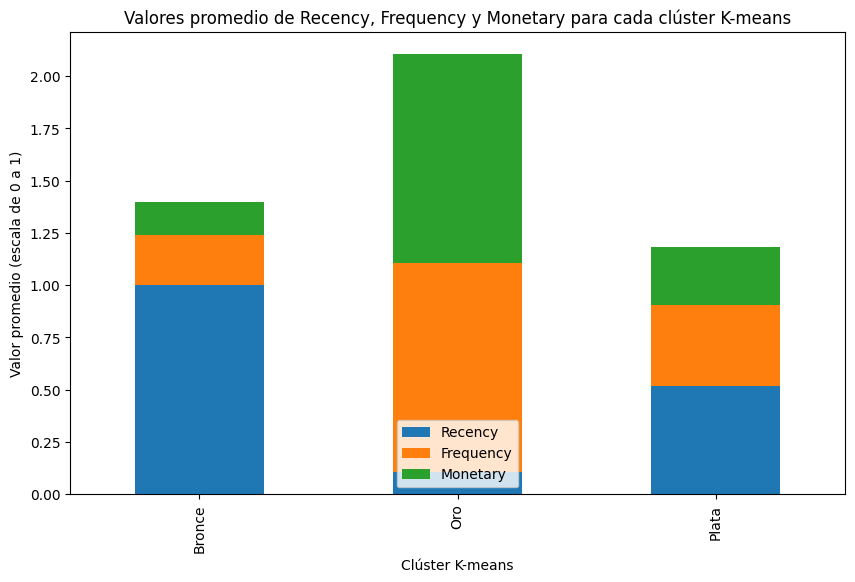

In [147]:
# Exclude the "Especial" segment
rfm_with_clusters_no_especial = rfm_with_clusters[rfm_with_clusters['Cluster'] != 'Especial']

# Calculate average RFM values for each cluster
cluster_avgs_no_especial = rfm_with_clusters_no_especial.groupby('Cluster').mean()

# Normalize each column by its own max
scaled_avgs_no_especial = cluster_avgs_no_especial[['Recency', 'Frequency', 'Monetary']].div(cluster_avgs_no_especial[['Recency', 'Frequency', 'Monetary']].max())

scaled_avgs_no_especial.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Valores promedio de Recency, Frequency y Monetary para cada clúster K-means')
plt.xlabel('Clúster K-means')
plt.ylabel('Valor promedio (escala de 0 a 1)')
plt.legend(loc='lower center')
plt.show()


## Especial (1 cliente):
Este grupo está compuesto por un solo cliente que ha realizado un número extremadamente alto de compras (2259) y ha gastado una cantidad de dinero excepcionalmente alta (1.448.167,36). Este cliente realizó su última compra el día más reciente en el conjunto de datos. Este cliente es claramente muy valioso para el negocio y cae en una categoría propia debido a su comportamiento de compra excepcional.

## Oro (2920 clientes):
Los clientes en este grupo han realizado sus últimas compras relativamente recientes (hace un promedio de 31 días antes de la última fecha en el conjunto de datos). Compran con relativa frecuencia (6,54 veces en promedio) y gastan una cantidad relativamente alta (2557,20 en promedio). Aunque estos clientes no compran tan frecuentemente ni gastan tanto como el cliente "Especial", todavía son muy valiosos para el negocio.

## Plata (817 clientes):
Los clientes en este grupo no han realizado compras tan recientemente como los del grupo Oro (hace un promedio de 152 días antes de la última fecha en el conjunto de datos). Compran con menos frecuencia (2,55 veces en promedio) y gastan menos (704,83 en promedio). Estos clientes son menos valiosos que los del grupo Oro, pero aún así son una parte importante de la base de clientes.

## Bronce (634 clientes):
Los clientes en este grupo realizaron sus últimas compras hace bastante tiempo (hace un promedio de 295 días antes de la última fecha en el conjunto de datos), compran con la menor frecuencia (1,56 veces en promedio) y gastan la menor cantidad (404,90 en promedio). Estos clientes son los menos valiosos de todos los grupos.

# ``CONCLUSIÓN``

La segmentación RFM nos permitió clasificar rápidamente a nuestros clientes en categorías fácilmente comprensibles (Oro, Plata, Bronce) basadas en su comportamiento de compra reciente, su frecuencia de compra y su gasto total. Esto nos proporciona una visión general del valor de los diferentes segmentos de clientes para el negocio y puede informar estrategias de marketing y retención de clientes de alto nivel.

Por otro lado, la segmentación K-means nos permitió detectar patrones más sutiles y específicos en los datos. Nos proporcionó un grupo adicional (Especial) para un cliente muy valioso que gastó una cantidad excepcionalmente alta. Aunque este grupo solo contiene un cliente, es crucial para el negocio debido a su alto valor. Este tipo de información detallada puede ser útil para estrategias de marketing y servicio al cliente más personalizadas y dirigidas.